<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/NSL_KDD_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


## **Get Data from Kaggle**

In [73]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kiranmahesh/nslkdd

! unzip nslkdd.zip

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nslkdd.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nslkdd.zip
replace kdd_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A n
  inflating: kdd_test.csv            
  inflating: kdd_train.csv           


# **Data Process**

In [74]:
# Get a list of files from this dir
files_list = os.listdir()

#files_list.sort()

files_list

['.config',
 'nslkdd.zip',
 'kdd_test.csv',
 'kaggle.json',
 'kaggle (1).json',
 'kdd_train.csv',
 'sample_data']

## **Read in Data**

Since Test and Train data comtain some different labels, we combine them together and then split into training and testing sets later

In [75]:
#INDEX =  0#@param {type:"integer"}

# Get df name
DATA = 'NSL-KDD'
print('DATA:', DATA)
csv_file = ['kdd_train.csv', 'kdd_test.csv']

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=',', header=0))

df = pd.concat(list_of_dataframes, ignore_index=True)
df

#test_df = pd.read_csv('kdd_test.csv', sep=',', header=0, engine='python')

DATA: NSL-KDD


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.0,0.00,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.2,0.00,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.0,0.00,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,395,1,0.06,0.0,0.93,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.09,0.00,0.91,1.00,satan
148513,0,tcp,http,SF,254,2277,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,27,255,1.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00,normal
148514,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202,10,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,25,0.10,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
148515,0,tcp,private,RSTR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.00,0.0,0.50,1.0,0.50,1.00,0.00,255,1,0.00,0.58,0.57,0.00,0.00,0.00,0.58,1.00,portsweep


In [76]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000
mean,282.850980,4.051230e+04,1.722710e+04,0.000182,0.021822,0.000121,0.196994,0.002370,0.397308,0.276231,0.001448,0.001098,0.298525,0.012147,0.000458,0.004101,0.0,0.000013,0.010208,84.046729,27.926702,0.276324,0.274494,0.125636,0.126641,0.664048,0.064439,0.096870,182.866870,116.787910,0.524935,0.083248,0.147277,0.031895,0.276092,0.270477,0.124323,0.125298
std,2545.220043,5.409528e+06,3.703596e+06,0.013482,0.248406,0.014678,2.087903,0.058437,0.489342,22.490762,0.038021,0.045155,22.999664,0.468356,0.023778,0.099098,0.0,0.003670,0.100516,115.287822,73.544207,0.442347,0.442972,0.326640,0.329570,0.438869,0.184633,0.258977,98.964628,110.868085,0.448749,0.190616,0.308485,0.111598,0.440218,0.441200,0.312011,0.324583
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,84.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,65.000000,0.540000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.760000e+02,5.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,54451.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [77]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0
if filt.any == True:
  print(df.loc[:,filt])

## **Encoding Label**

In [78]:
# If a class has < 2 instances --> drop it
filt = df['labels'].value_counts() < 2
drop_class = filt[filt == True].index[0] # Assuming only 1 class has 1 instance

print('A class with only 1 instance is ',drop_class)

print('df shape before dropping:', df.shape)

# Filter only classes that have only 1 instance and then drop it.
class_filt = df['labels'] == drop_class
df.drop(index = df[class_filt].index , inplace=True) 
print('df shape after dropping:', df.shape)


A class with only 1 instance is  xsnoop
df shape before dropping: (148517, 42)
df shape after dropping: (148516, 42)


In [79]:
OG_labels = sorted(df['labels'].unique())
n_classes = len(OG_labels)

# Encoding label for test data
print('Before encoding Label: ', OG_labels)
lb_maker = LabelEncoder().fit(OG_labels)
df['encoded_labels'] = lb_maker.transform(df['labels'])

df.drop(columns=['labels'], inplace=True)
print(df.shape)

encoded_labels = sorted( list(df['encoded_labels'].unique()))

labels_dict = dict(zip(range(len(lb_maker.classes_)), lb_maker.classes_, ))
labels_dict

Before encoding Label:  ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'teardrop', 'warezclient', 'warezmaster', 'xlock', 'xterm']
(148516, 42)


{0: 'apache2',
 1: 'back',
 2: 'buffer_overflow',
 3: 'ftp_write',
 4: 'guess_passwd',
 5: 'httptunnel',
 6: 'imap',
 7: 'ipsweep',
 8: 'land',
 9: 'loadmodule',
 10: 'mailbomb',
 11: 'mscan',
 12: 'multihop',
 13: 'named',
 14: 'neptune',
 15: 'nmap',
 16: 'normal',
 17: 'perl',
 18: 'phf',
 19: 'pod',
 20: 'portsweep',
 21: 'processtable',
 22: 'ps',
 23: 'rootkit',
 24: 'saint',
 25: 'satan',
 26: 'sendmail',
 27: 'smurf',
 28: 'snmpgetattack',
 29: 'snmpguess',
 30: 'spy',
 31: 'teardrop',
 32: 'warezclient',
 33: 'warezmaster',
 34: 'xlock',
 35: 'xterm'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [80]:
# Removing NaN
df.dropna(axis=1, how='any', inplace=True)

df.shape

(148516, 42)

In [81]:
# Encoding protocol_type
print(df['protocol_type'].unique())

encoder = LabelEncoder().fit(df['protocol_type'])
df['encoded_protocol_type'] = encoder.transform(df['protocol_type'])

df.drop(columns=['protocol_type'], inplace=True)
print(df.shape)
df.head()

['tcp' 'udp' 'icmp']
(148516, 42)


,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type
0,0,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1
1,0,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2
2,0,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1
3,0,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1
4,0,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1


In [82]:
# Encoding service for train data
services = df['service'].unique().tolist()
services.sort()
print(len(services), services)

# Encoding label: 1 is normal, 0 is intrusion
encoder = LabelEncoder().fit(df['service'])
df['encoded_service'] = encoder.transform(df['service'])
#print(protocol_encoder.classes_)

df.drop(columns=['service'], inplace=True)
print(df.shape)
df.head()

70 ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
(148516, 42)


,duration,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type,encoded_service
0,0,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1,20
1,0,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2,44
2,0,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1,49
3,0,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1,24
4,0,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1,24


In [83]:
# Encoding flag for train data
flags = df['flag'].unique().tolist()
flags.sort()
print(len(flags), flags)
encoder = LabelEncoder().fit(df['flag'])
df['encoded_flag'] = encoder.transform(df['flag'])

df.drop(columns=['flag'], inplace=True)
print(df.shape)

df.head()

11 ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']
(148516, 42)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type,encoded_service,encoded_flag
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1,20,9
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2,44,9
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1,49,5
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1,24,9
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1,24,9


In [84]:
# Move col Labels to the last col
df['Labels'] = df['encoded_labels']
df.drop(columns=['encoded_labels'], inplace= True)
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_protocol_type,encoded_service,encoded_flag,Labels
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,20,9,16
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.0,0.00,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,2,44,9,16
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,49,5,14
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.2,0.00,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,24,9,16
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.0,0.00,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,24,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,395,1,0.06,0.0,0.93,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.09,0.00,0.91,1.00,1,49,1,25
148513,0,254,2277,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,27,255,1.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00,1,24,9,16
148514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202,10,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,25,0.10,0.07,0.00,0.00,1.00,1.00,0.00,0.00,1,49,5,14
148515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.00,0.0,0.50,1.0,0.50,1.00,0.00,255,1,0.00,0.58,0.57,0.00,0.00,0.00,0.58,1.00,1,49,4,20


## **Feature Selection**

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df['Labels']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
print(best_features)  #print 30 best features


                          Specs          Score
4                wrong_fragment  229364.984731
25                same_srv_rate   29867.847264
3                          land   12119.298899
35     dst_host_srv_serror_rate   11153.392119
34         dst_host_serror_rate   10768.813084
22              srv_serror_rate   10600.441470
21                  serror_rate   10513.693226
30       dst_host_same_srv_rate    8530.772212
33  dst_host_srv_diff_host_rate    7239.594446
40                 encoded_flag    6717.131145
29           dst_host_srv_count    5974.809371
19                        count    5341.483175
8                     logged_in    4896.915190
20                    srv_count    4148.726909
32  dst_host_same_src_port_rate    3926.679257
31       dst_host_diff_srv_rate    3443.323255
38        encoded_protocol_type    2678.066619
26                diff_srv_rate    2596.176754
28               dst_host_count    2367.741339
27           srv_diff_host_rate    1607.541095
37     dst_ho

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [86]:
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
 # print(row[ "Score"])
  if row[ "Score"] > 1000 :
    best_column_indices.append(index)

# Keep only columns w the best features
X = X.iloc[:, best_column_indices]
NUM_COLS = len(X.columns)
X 

,wrong_fragment,same_srv_rate,land,dst_host_srv_serror_rate,dst_host_serror_rate,srv_serror_rate,serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,encoded_flag,dst_host_srv_count,count,logged_in,srv_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,encoded_protocol_type,diff_srv_rate,dst_host_count,srv_diff_host_rate,dst_host_srv_rerror_rate,rerror_rate,srv_rerror_rate,num_failed_logins,duration,encoded_service,dst_host_rerror_rate
0,0,1.00,0,0.00,0.00,0.0,0.00,0.17,0.00,9,25,2,0,2,0.17,0.03,1,0.00,150,0.00,0.00,0.00,0.0,0,0,20,0.05
1,0,0.08,0,0.00,0.00,0.0,0.00,0.00,0.00,9,1,13,0,1,0.88,0.60,2,0.15,255,0.00,0.00,0.00,0.0,0,0,44,0.00
2,0,0.05,0,1.00,1.00,1.0,1.00,0.10,0.00,5,26,123,0,6,0.00,0.05,1,0.07,255,0.00,0.00,0.00,0.0,0,0,49,0.00
3,0,1.00,0,0.01,0.03,0.2,0.20,1.00,0.04,9,255,5,1,5,0.03,0.00,1,0.00,30,0.00,0.01,0.00,0.0,0,0,24,0.00
4,0,1.00,0,0.00,0.00,0.0,0.00,1.00,0.00,9,255,30,1,32,0.00,0.00,1,0.00,255,0.09,0.00,0.00,0.0,0,0,24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,0.00,0,0.00,0.09,0.0,0.06,0.00,0.00,1,1,395,0,1,0.00,1.00,1,1.00,255,0.00,1.00,0.93,1.0,0,0,49,0.91
148513,0,1.00,0,0.00,0.00,0.0,0.00,1.00,0.04,9,255,2,1,2,0.04,0.00,1,0.00,27,0.00,0.00,0.00,0.0,0,0,24,0.00
148514,0,0.05,0,1.00,1.00,1.0,1.00,0.10,0.00,5,25,202,0,10,0.00,0.07,1,0.07,255,0.00,0.00,0.00,0.0,0,0,49,0.00
148515,0,0.50,0,0.00,0.00,0.0,0.00,0.00,0.00,4,1,2,0,1,0.57,0.58,1,1.00,255,0.00,1.00,0.50,1.0,0,0,49,0.58


In [87]:
X.describe()

,wrong_fragment,same_srv_rate,land,dst_host_srv_serror_rate,dst_host_serror_rate,srv_serror_rate,serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,encoded_flag,dst_host_srv_count,count,logged_in,srv_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,encoded_protocol_type,diff_srv_rate,dst_host_count,srv_diff_host_rate,dst_host_srv_rerror_rate,rerror_rate,srv_rerror_rate,num_failed_logins,duration,encoded_service,dst_host_rerror_rate
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,0.021823,0.664045,0.000182,0.270478,0.276094,0.274496,0.276326,0.524938,0.031895,6.972676,116.788568,84.047288,0.397304,27.926883,0.147278,0.083248,1.054324,0.064440,182.866385,0.096871,0.125298,0.125637,0.126642,0.002370,282.851733,31.411013,0.124324
std,0.248407,0.438870,0.013482,0.441201,0.440219,0.442973,0.442348,0.448749,0.111598,2.716906,110.868167,115.288009,0.489342,73.544421,0.308485,0.190616,0.425445,0.184633,98.964784,0.258978,0.324584,0.326641,0.329571,0.058437,2545.228596,16.347714,0.312012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,5.000000,11.000000,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.540000,0.000000,9.000000,65.000000,14.000000,0.000000,7.000000,0.000000,0.020000,1.000000,0.000000,255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020000,9.000000,255.000000,143.000000,1.000000,18.000000,0.060000,0.070000,1.000000,0.060000,255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,0.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,255.000000,511.000000,1.000000,511.000000,1.000000,1.000000,2.000000,1.000000,255.000000,1.000000,1.000000,1.000000,1.000000,5.000000,54451.000000,69.000000,1.000000


In [88]:
y

0         16
1         16
2         14
3         16
4         16
          ..
148512    25
148513    16
148514    14
148515    20
148516    16
Name: Labels, Length: 148516, dtype: int64

## **Data Cleaning**

In [89]:
label_arr = np.arange(0, np.max(y.unique())+1)

label_arr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

Class 16 - normal: n=78588 (52.916%)
---------> Major class 16
Class 14 - neptune: n=47868 (32.231%)
Class 32 - warezclient: n=997 (0.671%)
Class 7 - ipsweep: n=4078 (2.746%)
Class 20 - portsweep: n=3302 (2.223%)
Class 31 - teardrop: n=996 (0.671%)
Class 15 - nmap: n=1699 (1.144%)
Class 25 - satan: n=4331 (2.916%)
Class 27 - smurf: n=3186 (2.145%)
Class 19 - pod: n=236 (0.159%)
Class 1 - back: n=1183 (0.797%)
Class 4 - guess_passwd: n=464 (0.312%)
Class 3 - ftp_write: n=10 (0.007%)
Class 12 - multihop: n=16 (0.011%)
Class 23 - rootkit: n=14 (0.009%)
Class 2 - buffer_overflow: n=47 (0.032%)
Class 6 - imap: n=13 (0.009%)
Class 33 - warezmaster: n=299 (0.201%)
Class 18 - phf: n=5 (0.003%)
Class 8 - land: n=20 (0.013%)
Class 9 - loadmodule: n=13 (0.009%)
Class 30 - spy: n=2 (0.001%)
Class 17 - perl: n=4 (0.003%)
Class 0 - apache2: n=228 (0.154%)
Class 11 - mscan: n=310 (0.209%)
Class 5 - httptunnel: n=41 (0.028%)
Class 21 - processtable: n=211 (0.142%)
Class 10 - mailbomb: n=94 (0.063%)
Cl

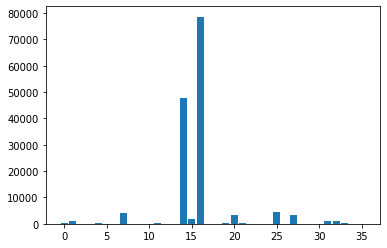

In [90]:
from collections import Counter

MAX_CASES = 1

# summarize distribution
counter = Counter(df['Labels'])
for k,v in counter.items():
  per = v / len(df['Labels']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [91]:
# get the encoded label of NORMAL class:
NORMAL_CLASS_INDEX = 0
for key, value in labels_dict.items():
  if value == 'normal':
    NORMAL_CLASS_INDEX = key
    break

print('The encoded label of NORMAL class is', NORMAL_CLASS_INDEX)

# check if normal class is the major class. If not, add normal class to another dataframe and add another sample of Normal dataframe into X; this way normal cases are oversampled.


The encoded label of NORMAL class is 16


## **Removing duplicates from multiple classes**

- Separate each class into a set
- Remove duplicate rows that exist in multiple classes by taking the difference between classes


In [92]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )


Before cleaning:
Class 0 len: 228
Class 1 len: 1030
Class 2 len: 39
Class 3 len: 9
Class 4 len: 412
Class 5 len: 41
Class 6 len: 11
Class 7 len: 3605
Class 8 len: 18
Class 9 len: 10
Class 10 len: 94
Class 11 len: 310
Class 12 len: 15
Class 13 len: 2
Class 14 len: 42612
Class 15 len: 1523
Class 16 len: 54148
Class 17 len: 4
Class 18 len: 5
Class 19 len: 206
Class 20 len: 2965
Class 21 len: 211
Class 22 len: 9
Class 23 len: 13
Class 24 len: 93
Class 25 len: 3862
Class 26 len: 8
Class 27 len: 2407
Class 28 len: 39
Class 29 len: 38
Class 30 len: 2
Class 31 len: 896
Class 32 len: 883
Class 33 len: 287
Class 34 len: 4
Class 35 len: 3


In [93]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
class_sz = {}
for key, value in cleaned_class_set.items():
  print( 'Class %d - %s len: %d' % (key, labels_dict[key], len(value)) )
  class_sz[key] = len(value)
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key
    
print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))

# Sort class by their sz. This list contains each class's size in descending order
sorted_class_sz = sorted(class_sz.values(), reverse=True)

After cleaning:
Class 0 - apache2 len: 228
Class 1 - back len: 1005
Class 2 - buffer_overflow len: 37
Class 3 - ftp_write len: 8
Class 4 - guess_passwd len: 411
Class 5 - httptunnel len: 41
Class 6 - imap len: 11
Class 7 - ipsweep len: 3573
Class 8 - land len: 14
Class 9 - loadmodule len: 10
Class 10 - mailbomb len: 94
Class 11 - mscan len: 310
Class 12 - multihop len: 13
Class 13 - named len: 2
Class 14 - neptune len: 42612
Class 15 - nmap len: 1517
Class 16 - normal len: 54083
Class 17 - perl len: 4
Class 18 - phf len: 5
Class 19 - pod len: 206
Class 20 - portsweep len: 2964
Class 21 - processtable len: 211
Class 22 - ps len: 7
Class 23 - rootkit len: 13
Class 24 - saint len: 92
Class 25 - satan len: 3861
Class 26 - sendmail len: 8
Class 27 - smurf len: 2407
Class 28 - snmpgetattack len: 33
Class 29 - snmpguess len: 38
Class 30 - spy len: 2
Class 31 - teardrop len: 896
Class 32 - warezclient len: 883
Class 33 - warezmaster len: 287
Class 34 - xlock len: 4
Class 35 - xterm len: 3
MAX 

# **Choosing Number of Labels**

In [94]:

def class_lookup(sz, class_sz = class_sz):
  for key, value in class_sz.items():
    if value == sz:
      # pop the key-value pair out of class_sz
      class_name = key
      class_sz.pop(key)
      return class_name

     
NUM_LABELS =  36#@param {type:"integer"}
sub_labels = []  # Store the old encoded labels of the biggest classes
for sz in range(NUM_LABELS):
  class_name = class_lookup(sorted_class_sz[sz])
  sub_labels.append(class_name)
  print( 'Class ', class_name, labels_dict[class_name], sorted_class_sz[sz])

  #if sz < 30:
  #  print(sz)
    # Look for class of that length
  #  small_class.append(class_lookup(sz, class_sz))


#print('List of classes w < 40 instances:', small_class)
#for i in small_class:
 # print(labels_dict[i])

Class  16 normal 54083
Class  14 neptune 42612
Class  25 satan 3861
Class  7 ipsweep 3573
Class  20 portsweep 2964
Class  27 smurf 2407
Class  15 nmap 1517
Class  1 back 1005
Class  31 teardrop 896
Class  32 warezclient 883
Class  4 guess_passwd 411
Class  11 mscan 310
Class  33 warezmaster 287
Class  0 apache2 228
Class  21 processtable 211
Class  19 pod 206
Class  10 mailbomb 94
Class  24 saint 92
Class  5 httptunnel 41
Class  29 snmpguess 38
Class  2 buffer_overflow 37
Class  28 snmpgetattack 33
Class  8 land 14
Class  12 multihop 13
Class  23 rootkit 13
Class  6 imap 11
Class  9 loadmodule 10
Class  3 ftp_write 8
Class  26 sendmail 8
Class  22 ps 7
Class  18 phf 5
Class  17 perl 4
Class  34 xlock 4
Class  35 xterm 3
Class  13 named 2
Class  30 spy 2


In [95]:
print('Num classes: ', len(sorted_class_sz))

Num classes:  36


In [96]:
new_X = pd.DataFrame()
new_Y = pd.Series()
#y = pd.DataFrame(y)

# Select data from sub_labels classes
for label in sub_labels:
  filt = y == label
  new_X = new_X.append(X[filt])
  new_Y = new_Y.append(y[filt])

new_X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,1.00,0,0.00,0.00,0.0,0.0,0.17,0.00,9,25,2,0,2,0.17,0.03,1,0.00,150,0.00,0.00,0.0,0.0,0,0,20,0.05
1,0,0.08,0,0.00,0.00,0.0,0.0,0.00,0.00,9,1,13,0,1,0.88,0.60,2,0.15,255,0.00,0.00,0.0,0.0,0,0,44,0.00
3,0,1.00,0,0.01,0.03,0.2,0.2,1.00,0.04,9,255,5,1,5,0.03,0.00,1,0.00,30,0.00,0.01,0.0,0.0,0,0,24,0.00
4,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.00,9,255,30,1,32,0.00,0.00,1,0.00,255,0.09,0.00,0.0,0.0,0,0,24,0.00
12,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.03,9,219,3,1,7,0.12,0.00,1,0.00,8,0.43,0.00,0.0,0.0,0,0,24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139752,0,1.00,0,0.00,0.00,0.0,0.0,0.41,0.02,9,96,1,1,1,0.01,0.05,1,0.00,95,0.00,0.52,0.0,0.0,0,54,60,0.17
136961,0,1.00,0,0.00,0.00,0.0,0.0,0.29,0.00,1,2,1,0,1,0.14,0.29,1,0.00,7,0.00,0.50,1.0,1.0,0,0,11,0.14
138203,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.00,1,1,1,0,1,1.00,0.00,1,0.00,1,0.00,1.00,1.0,1.0,0,0,11,1.00
21445,0,1.00,0,0.31,0.22,0.0,0.0,0.19,0.00,9,48,1,0,1,0.00,0.02,1,0.00,255,0.00,0.00,0.0,0.0,0,299,60,0.00


In [97]:
new_Y.unique()

array([16, 14, 25,  7, 20, 27, 15,  1, 31, 32,  4, 11, 33,  0, 21, 19, 10,
       24,  5, 29,  2, 28,  8, 12, 23,  6,  9,  3, 26, 22, 18, 17, 34, 35,
       13, 30])

In [98]:
# Decode label into its name again:
new_Y = pd.DataFrame(lb_maker.inverse_transform(new_Y))

# Update OG_labels and n_classes 
OG_labels = sorted(new_Y[0].unique())
n_classes = len(OG_labels)


# Encoding label for test data
print('Before encoding Label: ', OG_labels)
new_lb_maker = LabelEncoder().fit(OG_labels)
new_Y[0] = new_lb_maker.transform(new_Y[0])

# Update labels_dict
labels_dict = dict(zip(range(len(new_lb_maker.classes_)), new_lb_maker.classes_, ))

# Update Label arr aka an array of the newly encoded label
label_arr = np.arange(0, np.max(new_Y[0].unique())+1)

new_Y

Before encoding Label:  ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'teardrop', 'warezclient', 'warezmaster', 'xlock', 'xterm']


,0
0,16
1,16
2,16
3,16
4,16
...,...
148511,35
148512,13
148513,13
148514,30


In [99]:
labels_dict

{0: 'apache2',
 1: 'back',
 2: 'buffer_overflow',
 3: 'ftp_write',
 4: 'guess_passwd',
 5: 'httptunnel',
 6: 'imap',
 7: 'ipsweep',
 8: 'land',
 9: 'loadmodule',
 10: 'mailbomb',
 11: 'mscan',
 12: 'multihop',
 13: 'named',
 14: 'neptune',
 15: 'nmap',
 16: 'normal',
 17: 'perl',
 18: 'phf',
 19: 'pod',
 20: 'portsweep',
 21: 'processtable',
 22: 'ps',
 23: 'rootkit',
 24: 'saint',
 25: 'satan',
 26: 'sendmail',
 27: 'smurf',
 28: 'snmpgetattack',
 29: 'snmpguess',
 30: 'spy',
 31: 'teardrop',
 32: 'warezclient',
 33: 'warezmaster',
 34: 'xlock',
 35: 'xterm'}

**Upsampling minor classes**

Data is added to 2 different dataframes based on their classes.

*   Data in the biggest class, is added to major_X, which happens to be Normal class.
*   The rest of the data is added to sub_X (Most of the time intrusion data)

Why do we save data into 2 different sets?
Data from each of these dataframes are sampled differently:
*   Data from sub_X are bootstrapped to create the same number of records per class as data from major_X.
*   Then, these data are sampled w/o replacement to get N records per class. The sampling result is stored in X df.
*   Normal data (is most likely the major data aka major_X) are sampled without replacement to get 2xN records. The result is appended in X df.

==> As a result, X includes both normal and intrusion data. Then, split X into training and testing set



In [100]:
# Append major_X into sub_X to create X w/o bootstrapping
X = new_X
y = new_Y

# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,1.00,0,0.00,0.00,0.0,0.0,0.17,0.00,9,25,2,0,2,0.17,0.03,1,0.00,150,0.00,0.00,0.0,0.0,0,0,20,0.05
1,0,0.08,0,0.00,0.00,0.0,0.0,0.00,0.00,9,1,13,0,1,0.88,0.60,2,0.15,255,0.00,0.00,0.0,0.0,0,0,44,0.00
2,0,1.00,0,0.01,0.03,0.2,0.2,1.00,0.04,9,255,5,1,5,0.03,0.00,1,0.00,30,0.00,0.01,0.0,0.0,0,0,24,0.00
3,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.00,9,255,30,1,32,0.00,0.00,1,0.00,255,0.09,0.00,0.0,0.0,0,0,24,0.00
4,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.03,9,219,3,1,7,0.12,0.00,1,0.00,8,0.43,0.00,0.0,0.0,0,0,24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148511,0,1.00,0,0.00,0.00,0.0,0.0,0.41,0.02,9,96,1,1,1,0.01,0.05,1,0.00,95,0.00,0.52,0.0,0.0,0,54,60,0.17
148512,0,1.00,0,0.00,0.00,0.0,0.0,0.29,0.00,1,2,1,0,1,0.14,0.29,1,0.00,7,0.00,0.50,1.0,1.0,0,0,11,0.14
148513,0,1.00,0,0.00,0.00,0.0,0.0,1.00,0.00,1,1,1,0,1,1.00,0.00,1,0.00,1,0.00,1.00,1.0,1.0,0,0,11,1.00
148514,0,1.00,0,0.31,0.22,0.0,0.0,0.19,0.00,9,48,1,0,1,0.00,0.02,1,0.00,255,0.00,0.00,0.0,0.0,0,299,60,0.00


In [101]:
y 

,0
0,16
1,16
2,16
3,16
4,16
...,...
148511,35
148512,13
148513,13
148514,30


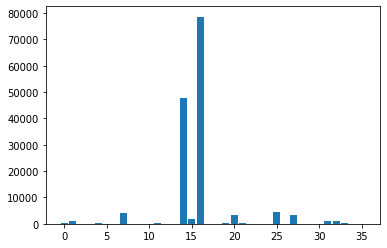

In [102]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y[0])

# **Data Partition**

Split X into train and test and ensure that the classes are stratified by classes in y

In [103]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((103961, 27), (103961, 1), (44555, 27), (44555, 1))

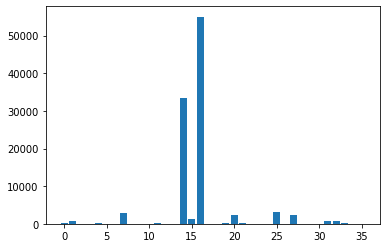

16    55011
14    33508
25     3032
7      2855
20     2311
27     2230
15     1189
1       828
32      698
31      697
4       325
11      217
33      209
19      165
0       160
21      148
29       69
10       66
24       65
2        33
28       30
5        29
8        14
12       11
23       10
9         9
6         9
3         7
22        6
26        6
18        4
17        3
34        3
35        2
13        1
30        1
dtype: int64

In [104]:
print_dist(y_train[0])
y_train.value_counts()

## Oversample

In [105]:
# get_majority_classes finds the 2 major classes and return their labels and sizes
def get_majority_classes(data, label):
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i
      
  print('Max Class %d has %d cases\nSecond Max Class %d len %d' % (max_class, max, max_2_class, max_2) )

  # Separate data into major_data and minor_data dfs
  filt = label == max_class
  major_y_train = label.loc[filt]
  filt2 = label == max_2_class
  major_y_train = major_y_train.append(label.loc[filt2])
  major_train = data.loc[data.index.isin(major_y_train.index)]
  major_train['Labels'] = major_y_train

  # Create minor_train by getting the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]

  return  major_train, minor_train


def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  major_train, minor_train = get_majority_classes(data, label)

  
  print('\n\nBefore upsampling minor classes:', minor_train.shape)
  minor_train = minor_train.groupby('Labels').sample(n = 5000, replace=True) 
  #minor_y_train = minor_train['Labels']

  print('After upsampling:', minor_train.shape, '\n')
  data = major_train.append(minor_train, ignore_index = True)
  data.drop(columns = ['Labels'], inplace = True)
  label = major_train['Labels'].append(minor_train['Labels']).astype('int32') #major_y_train.append(minor_y_train, ignore_index=True )
  #label.astype('int32')
  print_dist(label)

  return data, label

UP_SAMPLE = False #@param {type:"boolean"}
if UP_SAMPLE: 
  x_train, y_train = over_sample(x_train, y_train[0])
  #x_test,  y_test  = over_sample(x_test, y_test[0])

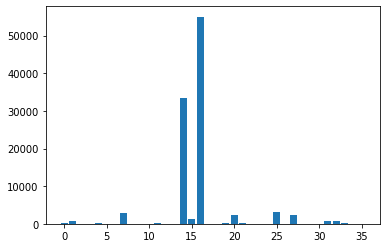

Max Class 16 has 55011 cases
Second Max Class 14 len 33508


Before downsampling minor classes: (15442, 28)
After downsampling: (15442, 28) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


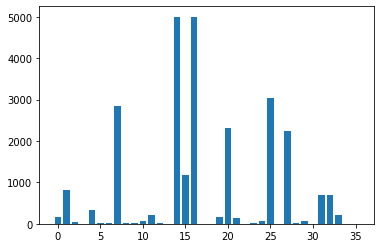

In [106]:
def down_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by downsampling major classes to the average of minor class

  # Look for the second biggest class
  major_train, minor_train = get_majority_classes(data, label)
  
  print('\n\nBefore downsampling minor classes:', minor_train.shape)
  #minor_train = minor_train.groupby('Labels').sample(n = 5000, replace=True) 
  #minor_y_train = minor_train['Labels']

  print('After downsampling:', minor_train.shape, '\n')
  major_train = major_train.groupby('Labels').sample(n = 5000, replace=False) 

  data = major_train.append(minor_train, ignore_index = True)
  data.drop(columns = ['Labels'], inplace = True)
  label = major_train['Labels'].append(minor_train['Labels'], ignore_index=True ).astype('int32')

  print_dist(label)

  return data, label

x_train, y_train = down_sample(x_train, y_train[0])

In [107]:
# Binarize y_train and y_test so that we can generate classification report and get AUC score per class
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_arr))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_arr))
else:
  y = pd.DataFrame(y)

#n_classes = y.shape[1]

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 36


((25442, 27), (25442, 36), (44555, 27), (44555, 36))

In [108]:
encoded_y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
encoded_y_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [110]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(10,6))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=2, fontsize = 10)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('\nTesting Accuracy: %.2f'% accuracy_score(true_labels, pred_labels))
  print('Micro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='micro', multi_class='ovr'))
  print('Macro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='macro', multi_class='ovr'))

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
 
  if n_classes < 20:
    large_vals = cmatrix.max()/2  #comment out because there are too many classes --> no need number
    for i in range(rows):
      for j in range(cols):
        if cmatrix[i, j] >= large_vals:
          color='white'
        else:
          color = 'black'
        plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)
  

## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])  
        roc_auc[i] = auc(fpr[i], tpr[i])

        #if np.isnan( roc_auc[i] ):
        #  roc_auc[i] = 0.5
        #print('ROC AUC Class ',i,':', roc_auc[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc
    
  else:
    #print('Binary classification')
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = auc(measures['fpr'], measures['tpr'])

  return measures


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (roc_type = 'micro'):
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT_fpr = DT_test.get('fpr')[roc_type];    DT_tpr = DT_test.get('tpr')[roc_type]; DT_auc = DT_test.get('auc')[roc_type]
    #print(DT, DT_auc)
    RF_fpr = RF_test.get('fpr')[roc_type];    RF_tpr = RF_test.get('tpr')[roc_type];    RF_auc  = RF_test.get('auc')[roc_type]
    KNN_fpr = KNN_test.get('fpr')[roc_type];  KNN_tpr = KNN_test.get('tpr')[roc_type];  KNN_auc = KNN_test.get('auc')[roc_type]
    LGBM_fpr = LGBM_test.get('fpr')[roc_type];LGBM_tpr = LGBM_test.get('tpr')[roc_type];LGBM_auc= LGBM_test.get('auc')[roc_type]
    XGB_fpr = XGB_test.get('fpr')[roc_type];  XGB_tpr = XGB_test.get('tpr')[roc_type];  XGB_auc = XGB_test.get('auc')[roc_type]
    BERT_fpr = BERT_test.get('fpr')[roc_type];BERT_tpr = BERT_test.get('tpr')[roc_type];BERT_auc= BERT_test.get('auc')[roc_type]
  else:
    DT_fpr = DT_test.get('fpr');      DT_tpr = DT_test.get('tpr');    DT_auc = DT_test.get('auc')
    RF_fpr = RF_test.get('fpr');      RF_tpr = RF_test.get('tpr');    RF_auc = RF_test.get('auc')
    KNN_fpr = KNN_test.get('fpr');    KNN_tpr = KNN_test.get('tpr');  KNN_auc = KNN_test.get('auc')
    LGBM_fpr = LGBM_test.get('fpr');  LGBM_tpr = LGBM_test.get('tpr'); LGBM_auc = LGBM_test.get('auc')
    XGB_fpr = XGB_test.get('fpr');    XGB_tpr = XGB_test.get('tpr');  XGB_auc = XGB_test.get('auc')
    BERT_fpr = BERT_test.get('fpr');  BERT_tpr = BERT_test.get('tpr');BERT_auc = BERT_test.get('auc')

  plt.plot(DT_fpr, DT_tpr,   markers.get('DT'),  color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF_fpr,  RF_tpr,  markers.get('RF'),  color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN_fpr, KNN_tpr, markers.get('KNN'), color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM_fpr,LGBM_tpr,markers.get('LGBM'),color=colors.get('LGBM'),label="LGBM - AUC=" +str( round(LGBM_auc, 4) ))
  plt.plot(XGB_fpr, XGB_tpr, markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))

  plt.plot(BERT_fpr, BERT_tpr, markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right',fontsize= 10) 
  plt.title( 'Testing '+ roc_type+' ROCs on ' + DATA)
  plt.show()

# **Decision Tree**

In [111]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

Confusion Matrix: 
 [[ 66   0   0 ...   0   0   0]
 [  3 341   0 ...   0   0   0]
 [  6   1   1 ...   0   0   0]
 ...
 [ 15   0   0 ...  75   0   0]
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       0.92      0.96      0.94        68
           back       0.67      0.96      0.79       355
buffer_overflow       0.50      0.07      0.12        14
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.61      0.87      0.72       139
     httptunnel       0.80      0.67      0.73        12
           imap       0.00      0.00      0.00         4
        ipsweep       0.78      0.99      0.87      1223
           land       0.44      0.67      0.53         6
     loadmodule       0.00      0.00      0.00         4
       mailbomb       0.27      0.93      0.41        28
          mscan       0.70      0.77      0.73        93
       multihop       

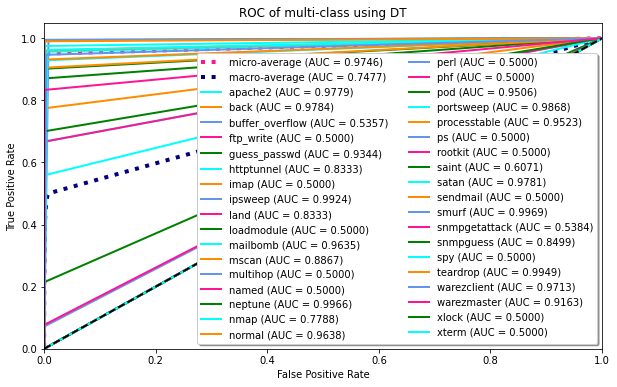

Train Macro AUC: 0.7619 vs Test Macro AUC: 0.7477


In [112]:
# Print performance measures
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')

if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(DT_train['auc']['macro'], DT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))

<Figure size 720x720 with 0 Axes>

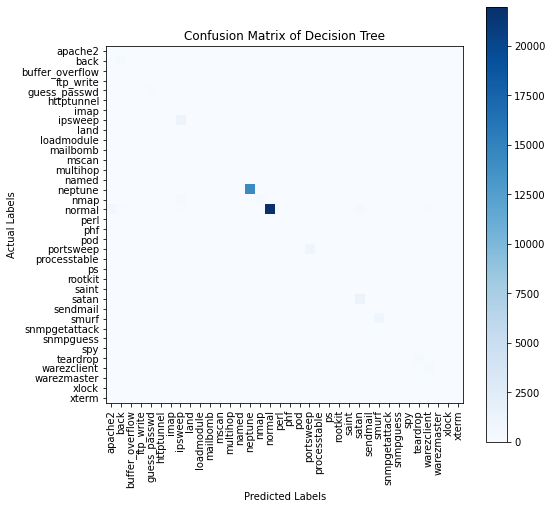

In [114]:
# TESTING Color Confusion Matrix 
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

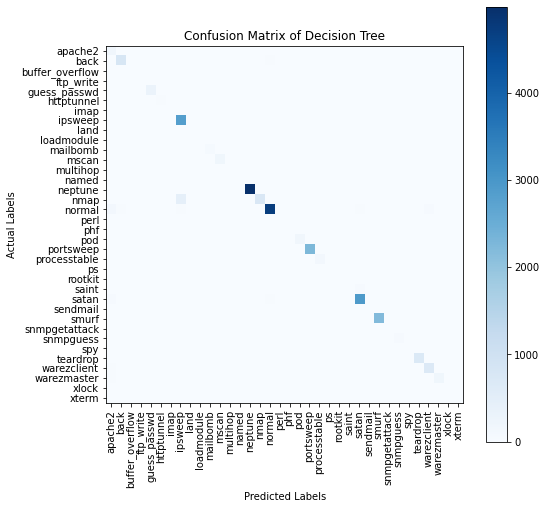

In [113]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_train, y_pred, OG_labels)

# **Random Forest**

In [115]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=20, n_jobs = -1, # added  -1 n_jobs
                                      max_features='auto', bootstrap=True, verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

Confusion Matrix: 
 [[ 68   0   0 ...   0   0   0]
 [  0 355   0 ...   0   0   0]
 [  9   0   0 ...   0   0   0]
 ...
 [  9   0   0 ...  80   0   0]
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      1.00      1.00        68
           back       0.84      1.00      0.91       355
buffer_overflow       0.00      0.00      0.00        14
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.95      0.91      0.93       139
     httptunnel       1.00      0.33      0.50        12
           imap       0.00      0.00      0.00         4
        ipsweep       0.99      0.99      0.99      1223
           land       0.60      0.50      0.55         6
     loadmodule       0.00      0.00      0.00         4
       mailbomb       1.00      0.96      0.98        28
          mscan       0.99      0.88      0.93        93
       multihop       

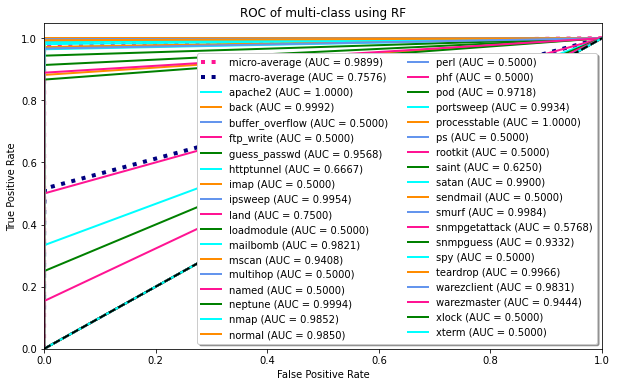

Train Macro AUC: 0.7787 vs Test Macro AUC: 0.7576


In [116]:
# Print performance measures
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(RF_train['auc']['macro'], RF_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc'], RF_test['auc']))

<Figure size 720x720 with 0 Axes>

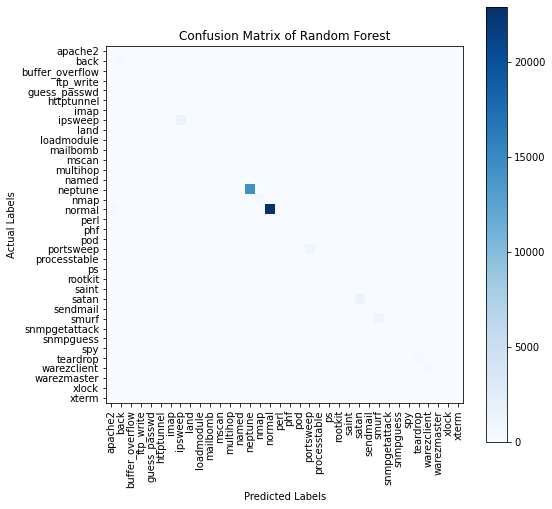

In [117]:
# TESTING Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

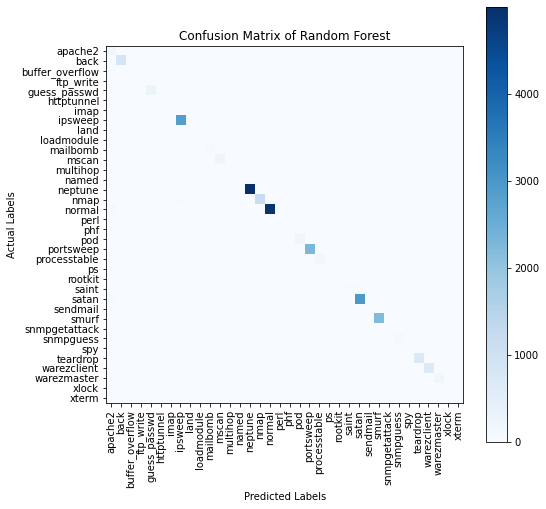

In [118]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_train, y_pred, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

In [119]:
#x_train_knn, y_train_knn = x_train.sample(n=7000)

Confusion Matrix: 
 [[ 67   0   0 ...   0   0   0]
 [  0 331   0 ...   0   0   0]
 [  2   0   5 ...   0   0   0]
 ...
 [  1   0   0 ...  71   0   0]
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       0.76      0.99      0.86        68
           back       0.40      0.93      0.56       355
buffer_overflow       0.19      0.36      0.24        14
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.41      0.81      0.54       139
     httptunnel       0.57      0.67      0.62        12
           imap       0.67      0.50      0.57         4
        ipsweep       0.79      0.95      0.86      1223
           land       0.57      0.67      0.62         6
     loadmodule       0.20      0.25      0.22         4
       mailbomb       0.12      0.57      0.21        28
          mscan       0.41      0.60      0.49        93
       multihop       

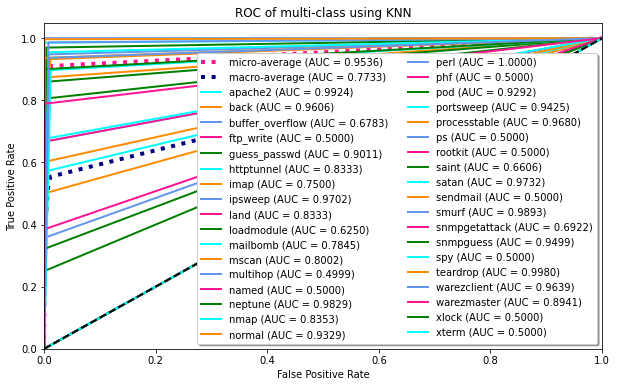

Train Macro AUC: 0.8135 vs Test Macro AUC: 0.7733


In [120]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(KNN_train['auc']['macro'], KNN_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc'], KNN_test['auc']))

<Figure size 720x720 with 0 Axes>

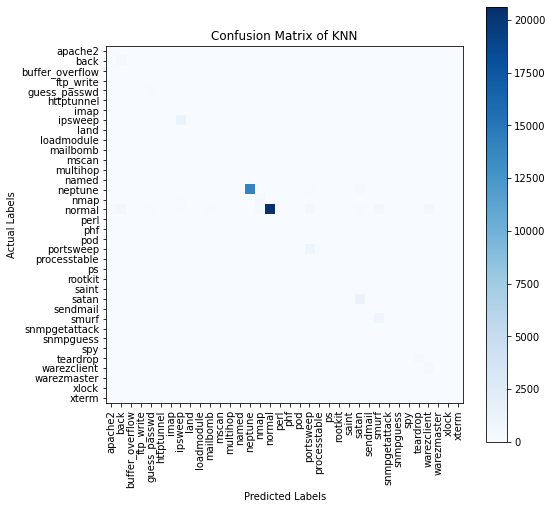

In [121]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

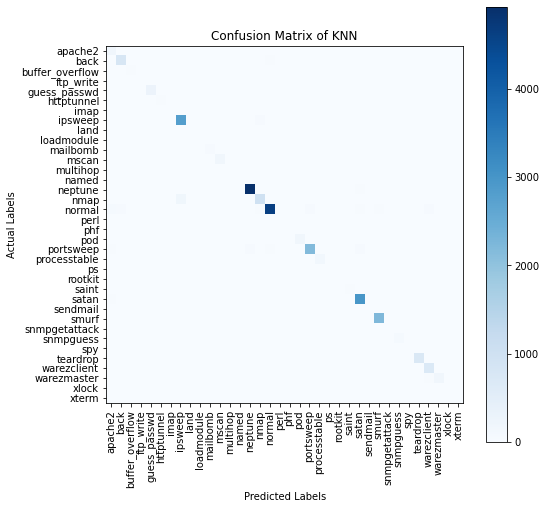

In [122]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_train, y_pred, OG_labels)

# **LightGBM**

<Figure size 720x720 with 0 Axes>

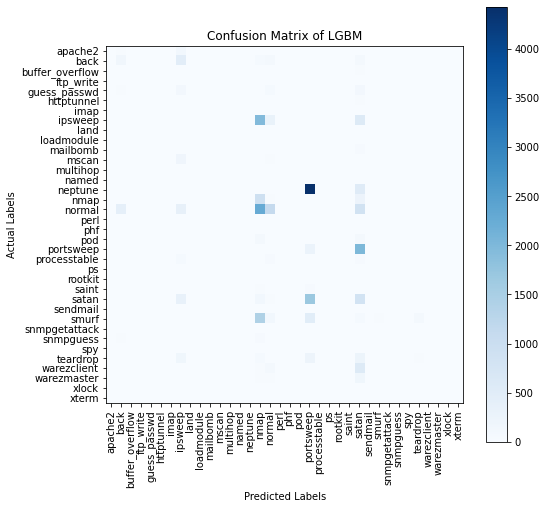

In [123]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass')
 
  #y_pred = label_binarize(y_pred, classes= label_arr)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted: 
y_pred_encoded = label_binarize(y_predicted, classes= label_arr)

# TRAINING Color Confusion Matrix
color_confusion_matrix('LGBM', encoded_y_train, y_pred, OG_labels)

Confusion Matrix: 
 [[ 0  3  0 ...  0  0  0]
 [ 0 62  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00        68
           back       0.03      0.17      0.06       355
buffer_overflow       0.00      0.00      0.00        14
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00       139
     httptunnel       0.00      0.00      0.00        12
           imap       0.00      0.00      0.00         4
        ipsweep       0.00      0.00      0.00      1223
           land       0.00      0.00      0.00         6
     loadmodule       0.00      0.00      0.00         4
       mailbomb       0.00      0.00      0.00        28
          mscan       0.00      0.00      0.00        93
       multihop       0.00      0.00      0.00         5
 

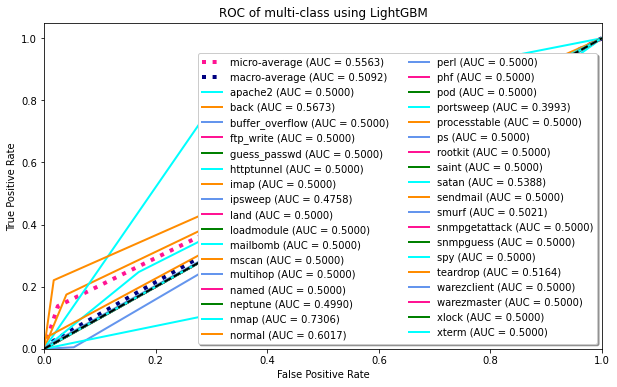

Train Macro AUC: 0.5087 vs Test Macro AUC: 0.5092


In [124]:
# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(LGBM_train['auc']['macro'],LGBM_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc'], LGBM_test['auc']))

<Figure size 720x720 with 0 Axes>

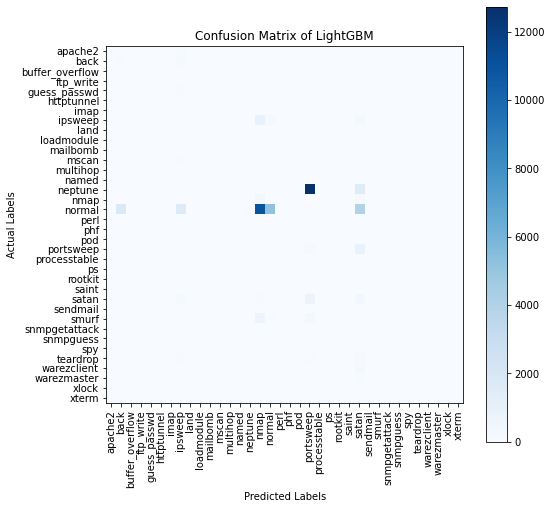

In [125]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="mlogloss", objective = "multi:softprob", )  ## change from logloss to mlogloss and add objective

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)


# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted, classes= label_arr)

# Color Confusion Matrix
color_confusion_matrix('XGB', encoded_y_train, y_pred, OG_labels)

In [ ]:
# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(XGB_train['auc']['macro'], XGB_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

# **Multi-class BERT**

In [ ]:
# plot the distribution
print_dist(y_train)

In [ ]:
# plot the distribution
print_dist(y_test[0])

## **Combining all features into a sentence**

In [ ]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

In [ ]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [ ]:
train_texts

In [ ]:
encoded_y_test.head()

In [ ]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

In [ ]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_arr), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
#y_label = to_categorical(train_labels)

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_y_train},
    validation_split=0.2,
    batch_size=64,
    epochs=2)

In [ ]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_arr)
# Recording TPR and FPR for TRAINING-ROC curves
BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
#test_y_label   = to_categorical(test_labels)

test_x = tokenizer(
    text= list(test_texts), 
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_y_test}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_arr)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
BERT_test = record_measures( encoded_y_test, y_pred_encoded) 

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(BERT_train['auc']['macro'], BERT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)


# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the Micro ROC curves on testing results:
graph_multi_ROC()

# Ploting the Macro ROC curves on testing results:
graph_multi_ROC('macro')

In [ ]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8889 --NotebookApp.port_retries=0

# **Note**

- Before cleaning data, BERT only get AUC = 0.86, while the other algs achieved AUC above 0.90.

- After cleaning data, BERT performance is improved to AUC = 0.92, and other algs has AUC above 0.93. However, since this dataset has 36 classes ( 1 normal and 35 intrusions), most algs do not classify normal cases well, they often mistake normal class for intrusion classes. 

--> We increased the number of cases per class from 135 to over 275, which improves f-1 score on normal class overall (F-1 Scores are above 0.77) --> still have room for improvement on normal class.
 
 --> We increase the number of cases from only normal class to see if its F1-Score can get better (Normal class vs. Intrusion classes ratio 2:1). Result: Only LightGBM and XGBoost gets better at classifying Normal class (F1-Score above 0.92), yet no improvement on DT, RF, KNN and BERT.

 --> Normal class vs. intrusion class ratio 2:1, and not removing intrusion classes from normal. Result: no difference

 --> Normal class vs. intrusion class ratio 1:1, and remove all intrusion classes from normal class. Result: Only LightGBM and XGBoost classify normal class well (Normal F1-Score above 0.88)


*   BERT note: when increasing number of training and testing sets to around 10K, BERT needs at least 10 epochs to efficiently train and validate and to achieve above 0.85 accuracy. --> Takes longer to run 
*   List item


**Next Step:**
- Narrowing down the number of classes by including only 5 or 10 classes in the training and testing sets. The purpose of this experiment is to see if BERT performance is improved when there are fewer classes. 

**Current Code Note**

This current version do not oversample minor classes. The training and testing sets are split based on stratified y. 
--> LightGBM do not work well on extremely imbalance data, so it yields the worst result. Yet BERT is doing pretty well so far

Most algorithms achieve high accuracy but low AUC due to the major class is Normal. 

When undersample major classes in train set, most algs perform similar to when upsampling minor classes except LGBM and XGB, which perform slightly better than when upsampling minor classes. Overall, downsampling reduces training time significantly without affect the models' micro and macro performances. When upsampling, LGBM performs poorly on neptune (0.59) and normal classes (0.53) (aka the 2 major classes). However, its performance on these 2 classes improve significantly (neptune - 0.8 and normal - 0.66). 

1.   List item
2.   List item

